In [1]:
import os
os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # minder spam, optioneel


import tensorflow as tf
tf.config.optimizer.set_jit(False)
from tensorflow.keras import layers, models
import json
import numpy as np
import pandas as pd

import datetime
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


DATASET_PATH = "resources/games/mm456.json"
MODEL_EXPORT_PATH = "resources/models/"
SELECTED_PLAYERS = []
DISCOUNT_FACTOR = 0.98
EPOCHS = 20
BATCH_SIZE = 512
N_CORES = 8
LEARNING_RATE = 0.001

os.environ["OMP_NUM_THREADS"] = str(N_CORES)
os.environ["TF_NUM_INTRAOP_THREADS"] = str(N_CORES)
os.environ["TF_NUM_INTEROP_THREADS"] = str(N_CORES)

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.20.0


In [2]:
def build_dataset(path):
    """
    CRITICAL FIX: Generate training data from BOTH players' perspectives.

    The key insight: In a two-player zero-sum game, we need to train the model
    to evaluate positions from a consistent perspective. We do this by:
    1. For each board position, create TWO training examples
    2. One from Light's perspective (original board, positive if Light wins)
    3. One from Dark's perspective (inverted board, positive if Dark wins)
    """
    with open(path) as f:
        data = json.load(f)

    print(f"Processing {len(data)} games")

    boards = []
    scores = []

    for game_idx, game in enumerate(data):
        # Skip games that don't have both players in the selected players list
        if SELECTED_PLAYERS and (
                game["lightPlayer"] not in SELECTED_PLAYERS or
                game["darkPlayer"] not in SELECTED_PLAYERS
        ):
            continue

        winner = game["winner"]  # 1 for Light, -1 for Dark
        n_moves = len(game["boardHistory"])
        reserve_size = game['reserveSize']

        for i, board_as_long in enumerate(game["boardHistory"]):
            # Convert board to array (0 = Light, 1 = Dark)
            board_as_array = np.array(
                [(board_as_long >> j) & 1 for j in range(59, -1, -1)],
                dtype=np.float32
            )

            # Calculate discount based on proximity to end of game
            # Positions closer to the end are more certain
            discount = DISCOUNT_FACTOR ** (n_moves - i - 1)

            # Light's perspective: positive if Light wins
            light_score = winner * discount * reserve_size
            boards.append(board_as_array)
            scores.append(light_score)

            # Dark's perspective: flip the board (0->1, 1->0) and score
            # This teaches the model to evaluate from the active player's view
            dark_board = 1.0 - board_as_array
            dark_score = -winner * discount * reserve_size  # Flip the score
            boards.append(dark_board)
            scores.append(dark_score)

        if game_idx % 1000 == 0:
            print(f"Processed game {game_idx}/{len(data)}")

    boards_array = np.array(boards, dtype=np.float32)
    scores_array = np.array(scores, dtype=np.float32)

    # Shuffle the dataset to mix Light and Dark perspectives
    indices = np.random.permutation(len(boards_array))

    return boards_array[indices], scores_array[indices]



In [3]:
def build_conv1d_model(
        filters1=32,
        filters2=64,
        kernel_size=3,
        dense_units1=64,
        dense_units2=32,
        dropout=0.3,
):
    """
    Conv1D-model dat de 60 velden als sequentie ziet: (60, 1)
    """
    inputs = layers.Input(shape=(60,), dtype=tf.float32)

    x = layers.Reshape((60, 1))(inputs)  # (batch, 60, 1)

    x = layers.Conv1D(filters1, kernel_size=kernel_size,
                      activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(filters2, kernel_size=kernel_size,
                      activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Flatten()(x)

    x = layers.Dense(dense_units1, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Dense(dense_units2, activation='relu')(x)
    x = layers.BatchNormalization()(x)

    outputs = layers.Dense(1)(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

def build_conv1d_deep_model(
        filters1=64,
        filters2=128,
        filters3=256,
        kernel_size=5,
        dense_units1=128,
        dense_units2=64,
        dropout=0.4,
):
    """
    Dieper Conv1D-model: 3 conv-blokken + GlobalAveragePooling1D.
    Ziet het bord als sequentie (60, 1).
    """
    inputs = layers.Input(shape=(60,), dtype=tf.float32)
    x = layers.Reshape((60, 1))(inputs)  # (batch, 60, 1)

    # Block 1
    x = layers.Conv1D(filters1, kernel_size=kernel_size,
                      activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)

    # Block 2
    x = layers.Conv1D(filters2, kernel_size=kernel_size,
                      activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)

    # Block 3 (extra laag)
    x = layers.Conv1D(filters3, kernel_size=kernel_size,
                      activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)

    # In plaats van Flatten: global pooling (minder parameters, vaak beter)
    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(dense_units1, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Dense(dense_units2, activation="relu")(x)
    x = layers.BatchNormalization()(x)

    outputs = layers.Dense(1)(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

def residual_block(x, filters, kernel_size):
    shortcut = x

    y = layers.Conv1D(filters, kernel_size,
                      padding="same", activation="relu")(x)
    y = layers.BatchNormalization()(y)
    y = layers.Conv1D(filters, kernel_size,
                      padding="same", activation=None)(y)
    y = layers.BatchNormalization()(y)

    # skip connection
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv1D(filters, 1, padding="same")(shortcut)

    out = layers.Add()([shortcut, y])
    out = layers.Activation("relu")(out)
    return out


def build_conv1d_resnet_model(
        filters1=64,
        filters2=128,
        kernel_size=5,
        dense_units1=128,
        dense_units2=64,
        dropout=0.4,
):
    inputs = layers.Input(shape=(60,), dtype=tf.float32)
    x = layers.Reshape((60, 1))(inputs)

    # Residual block 1
    x = residual_block(x, filters1, kernel_size)

    # Residual block 2
    x = residual_block(x, filters2, kernel_size)

    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(dense_units1, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Dense(dense_units2, activation="relu")(x)
    x = layers.BatchNormalization()(x)

    outputs = layers.Dense(1)(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    return model


In [4]:
def train_single_experiment(
        model_builder,
        model_kwargs,
        optimizer,       # bv. tf.keras.optimizers.Adam
        learning_rate,
        batch_size,
        X_train, y_train,
        X_val, y_val,
        X_test, y_test,
        label,
        arch_name,
):
    print(f"\n==== Running experiment: {label} ====")

    model = model_builder(**model_kwargs)
    model.summary()
    opt = optimizer(learning_rate=learning_rate)   # optimizer class rechtstreeks

    model.compile(
        optimizer=opt,
        loss="mse",
        metrics=["mae"]
    )

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=4,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=2,
            min_lr=1e-6
        )
    ]

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=0,
    )

    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

    best_val_loss = float(min(history.history["val_loss"]))
    best_val_mae = float(min(history.history["val_mae"]))

    print(f"Best val_loss: {best_val_loss:.4f}, best val_mae: {best_val_mae:.4f}")
    print(f"Test loss:     {test_loss:.4f}, test MAE:     {test_mae:.4f}")

    result = {
        "label": label,
        "arch_name": arch_name,
        "optimizer": optimizer.__name__,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "best_val_loss": best_val_loss,
        "best_val_mae": best_val_mae,
        "test_loss": test_loss,
        "test_mae": test_mae,
        "history": history.history,
    }
    return result


In [5]:
def run_experiments(X_train, y_train, X_val, y_val, X_test, y_test):
    # 1) Architecturen definiëren
    conv1d_archs = [
        {
            "name": "conv1d_large",
            "builder": build_conv1d_model,
            "kwargs": dict(
                filters1=96, filters2=192,
                kernel_size=5,
                dense_units1=128, dense_units2=64,
                dropout=0.4,
            ),
        },
        {
            "name": "conv1d_xlarge",
            "builder": build_conv1d_model,
            "kwargs": dict(
                filters1=128, filters2=256,
                kernel_size=5,
                dense_units1=256, dense_units2=128,
                dropout=0.5,
            ),
        },
        {
            "name": "conv1d_deep",
            "builder": build_conv1d_deep_model,  
            "kwargs": dict(
                filters1=128, filters2=256,
                filters3=256,
                kernel_size=5,
                dense_units1=256, dense_units2=128,
                dropout=0.5,
            ),
        },
          {
        "name": "conv1d_resnet",
        "builder": build_conv1d_resnet_model,
        "kwargs": dict(
            filters1=128,
            filters2=256,
            kernel_size=5,
            dense_units1=256,
            dense_units2=128,
            dropout=0.5,
        ),
    },
    ]

    # 2) Hyperparameters
    conv_optimizers = [tf.keras.optimizers.Adam]  # enkel Adam
    conv_lrs = [0.0005, 0.0008, 0.001, 0.0012]
    conv_batch_sizes = [256, 512]

    # 3) Experimentenlijst opbouwen
    experiments = []
    for arch in conv1d_archs:
        for opt_func in conv_optimizers:
            for lr in conv_lrs:
                for bs in conv_batch_sizes:
                    label = f"{arch['name']}_lr{lr}_bs{bs}"
                    experiments.append({
                        "label": label,
                        "arch_name": arch["name"],
                        "model_builder": arch["builder"],
                        "model_kwargs": arch["kwargs"],
                        "optimizer": opt_func,
                        "learning_rate": lr,
                        "batch_size": bs,
                    })

    print(f"Running {len(experiments)} experiments...\n")

    # 4) Experimenten uitvoeren
    results = []
    for i, exp in enumerate(experiments):
        print(f"\n=== Experiment {i+1}/{len(experiments)}: {exp['label']} ===")
        res = train_single_experiment(
            model_builder=exp["model_builder"],
            model_kwargs=exp["model_kwargs"],
            optimizer=exp["optimizer"],
            learning_rate=exp["learning_rate"],
            batch_size=exp["batch_size"],
            X_train=X_train, y_train=y_train,
            X_val=X_val, y_val=y_val,
            X_test=X_test, y_test=y_test,
            label=exp["label"],
            arch_name=exp["arch_name"],
        )
        results.append(res)

    # 5) DataFrame maken
    df = pd.DataFrame([
        {
            "label": r["label"],
            "arch_name": r["arch_name"],
            "optimizer": r["optimizer"],
            "learning_rate": r["learning_rate"],
            "batch_size": r["batch_size"],
            "best_val_loss": r["best_val_loss"],
            "best_val_mae": r["best_val_mae"],
            "test_loss": r["test_loss"],
            "test_mae": r["test_mae"],
        }
        for r in results
    ])

    # 6) Plots genereren
    plot_results(df)

    # 7) Beste experiment tonen (optioneel)
    best_row = df.sort_values("test_mae").iloc[0]
    print("\nBest experiment based on test MAE:")
    print(best_row)

    return results, df


In [6]:
def plot_results(df: pd.DataFrame):
    # Zorg dat de sortering klopt
    df_sorted = df.sort_values("test_mae")

    # 1) Top 10 beste experimenten (test_mae)
    top10 = df_sorted.head(10)
    plt.figure(figsize=(12, 6))
    plt.barh(top10["label"], top10["test_mae"])
    plt.gca().invert_yaxis()
    plt.xlabel("Test MAE (lager is beter)")
    plt.title("Top 10 experimenten op basis van Test MAE")
    plt.tight_layout()
    plt.show()

    # 2) Scatter: learning rate vs test_mae
    plt.figure(figsize=(8, 6))
    plt.scatter(df["learning_rate"], df["test_mae"])
    plt.xscale("log")
    plt.xlabel("Learning rate")
    plt.ylabel("Test MAE")
    plt.title("Effect van learning rate op Test MAE")
    plt.tight_layout()
    plt.show()

    # 3) Gemiddelde Test MAE per batch size
    plt.figure(figsize=(8, 6))
    df.groupby("batch_size")["test_mae"].mean().plot(kind="bar")
    plt.ylabel("Gemiddelde Test MAE (lager is beter)")
    plt.xlabel("Batch size")
    plt.title("Gemiddelde Test MAE per batch size")
    plt.tight_layout()
    plt.show()


TensorFlow version: 2.20.0
Loading dataset...
Processing 30000 games
Processed game 0/30000
Processed game 1000/30000
Processed game 2000/30000
Processed game 3000/30000
Processed game 4000/30000
Processed game 5000/30000
Processed game 6000/30000
Processed game 7000/30000
Processed game 8000/30000
Processed game 9000/30000
Processed game 10000/30000
Processed game 11000/30000
Processed game 12000/30000
Processed game 13000/30000
Processed game 14000/30000
Processed game 15000/30000
Processed game 16000/30000
Processed game 17000/30000
Processed game 18000/30000
Processed game 19000/30000
Processed game 20000/30000
Processed game 21000/30000
Processed game 22000/30000
Processed game 23000/30000
Processed game 24000/30000
Processed game 25000/30000
Processed game 26000/30000
Processed game 27000/30000
Processed game 28000/30000
Processed game 29000/30000
Train size: 1604279
Val size:   401069
Test size:  501336
Running 32 experiments...


=== Experiment 1/32: conv1d_large_lr0.0005_bs256

I0000 00:00:1763679489.648246  260347 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 60, 96)         │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60, 96)         │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 60, 192)        │        92,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 60, 192)        │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 11520)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,474,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,577,857 (6.02 MB)

 Trainable params: 1,576,897 (6.02 MB)

 Non-trainable params: 960 (3.75 KB)

I0000 00:00:1763679497.171488  260466 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Best val_loss: 1.1006, best val_mae: 0.8385
Test loss:     1.1042, test MAE:     0.8397

=== Experiment 2/32: conv1d_large_lr0.0005_bs512 ===

==== Running experiment: conv1d_large_lr0.0005_bs512 ====


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 60, 96)         │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 60, 96)         │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 60, 192)        │        92,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 60, 192)        │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 11520)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     1,474,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,577,857 (6.02 MB)

 Trainable params: 1,576,897 (6.02 MB)

 Non-trainable params: 960 (3.75 KB)

Best val_loss: 1.1009, best val_mae: 0.8359
Test loss:     1.1031, test MAE:     0.8360

=== Experiment 3/32: conv1d_large_lr0.0008_bs256 ===

==== Running experiment: conv1d_large_lr0.0008_bs256 ====


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 60, 96)         │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 60, 96)         │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 60, 192)        │        92,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 60, 192)        │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 11520)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     1,474,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,577,857 (6.02 MB)

 Trainable params: 1,576,897 (6.02 MB)

 Non-trainable params: 960 (3.75 KB)

Best val_loss: 1.0971, best val_mae: 0.8350
Test loss:     1.0994, test MAE:     0.8351

=== Experiment 4/32: conv1d_large_lr0.0008_bs512 ===

==== Running experiment: conv1d_large_lr0.0008_bs512 ====


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 60, 96)         │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 60, 96)         │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 60, 192)        │        92,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 60, 192)        │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 11520)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │     1,474,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,577,857 (6.02 MB)

 Trainable params: 1,576,897 (6.02 MB)

 Non-trainable params: 960 (3.75 KB)

Best val_loss: 1.1117, best val_mae: 0.8439
Test loss:     1.1150, test MAE:     0.8447

=== Experiment 5/32: conv1d_large_lr0.001_bs256 ===

==== Running experiment: conv1d_large_lr0.001_bs256 ====


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 60, 96)         │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 60, 96)         │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 60, 192)        │        92,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 60, 192)        │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 11520)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     1,474,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,577,857 (6.02 MB)

 Trainable params: 1,576,897 (6.02 MB)

 Non-trainable params: 960 (3.75 KB)

Best val_loss: 1.1121, best val_mae: 0.8429
Test loss:     1.1153, test MAE:     0.8441

=== Experiment 6/32: conv1d_large_lr0.001_bs512 ===

==== Running experiment: conv1d_large_lr0.001_bs512 ====


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 60, 96)         │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 60, 96)         │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 60, 192)        │        92,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 60, 192)        │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 11520)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │     1,474,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,577,857 (6.02 MB)

 Trainable params: 1,576,897 (6.02 MB)

 Non-trainable params: 960 (3.75 KB)

Best val_loss: 1.1262, best val_mae: 0.8547
Test loss:     1.1309, test MAE:     0.8565

=== Experiment 7/32: conv1d_large_lr0.0012_bs256 ===

==== Running experiment: conv1d_large_lr0.0012_bs256 ====


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 60, 96)         │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 60, 96)         │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 60, 192)        │        92,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 60, 192)        │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 11520)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │     1,474,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,577,857 (6.02 MB)

 Trainable params: 1,576,897 (6.02 MB)

 Non-trainable params: 960 (3.75 KB)

Best val_loss: 1.1045, best val_mae: 0.8380
Test loss:     1.1059, test MAE:     0.8382

=== Experiment 8/32: conv1d_large_lr0.0012_bs512 ===

==== Running experiment: conv1d_large_lr0.0012_bs512 ====


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_7 (Reshape)             │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 60, 96)         │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 60, 96)         │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 60, 192)        │        92,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 60, 192)        │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 11520)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │     1,474,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,577,857 (6.02 MB)

 Trainable params: 1,576,897 (6.02 MB)

 Non-trainable params: 960 (3.75 KB)

Best val_loss: 1.1313, best val_mae: 0.8586
Test loss:     1.1345, test MAE:     0.8594

=== Experiment 9/32: conv1d_xlarge_lr0.0005_bs256 ===

==== Running experiment: conv1d_xlarge_lr0.0005_bs256 ====


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_8 (Reshape)             │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 60, 128)        │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 60, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 60, 256)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 60, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 15360)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │     3,932,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,133,377 (15.77 MB)

 Trainable params: 4,131,841 (15.76 MB)

 Non-trainable params: 1,536 (6.00 KB)

Best val_loss: 1.0068, best val_mae: 0.7916
Test loss:     1.0076, test MAE:     0.7918

=== Experiment 10/32: conv1d_xlarge_lr0.0005_bs512 ===

==== Running experiment: conv1d_xlarge_lr0.0005_bs512 ====


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_9 (Reshape)             │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 60, 128)        │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 60, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 60, 256)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 60, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 15360)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 256)            │     3,932,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,133,377 (15.77 MB)

 Trainable params: 4,131,841 (15.76 MB)

 Non-trainable params: 1,536 (6.00 KB)

2025-11-21 01:36:10.844562: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng18{k11=2} for conv (f32[256,128,1,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[512,128,1,60]{3,2,1,0}, f32[512,256,1,60]{3,2,1,0}), window={size=1x5 pad=0_0x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]} is taking a while...
2025-11-21 01:36:11.362104: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.519012261s
Trying algorithm eng18{k11=2} for conv (f32[256,128,1,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[512,128,1,60]{3,2,1,0}, f32[512,256,1,60]{3,2,1,0}), window={size=1x5 pad=0_0x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config=

Best val_loss: 1.0384, best val_mae: 0.8089
Test loss:     1.0431, test MAE:     0.8146

=== Experiment 11/32: conv1d_xlarge_lr0.0008_bs256 ===

==== Running experiment: conv1d_xlarge_lr0.0008_bs256 ====


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_10 (Reshape)            │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 60, 128)        │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 60, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 60, 256)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 60, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 15360)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 256)            │     3,932,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,133,377 (15.77 MB)

 Trainable params: 4,131,841 (15.76 MB)

 Non-trainable params: 1,536 (6.00 KB)

Best val_loss: 1.0178, best val_mae: 0.7950
Test loss:     1.0183, test MAE:     0.7962

=== Experiment 12/32: conv1d_xlarge_lr0.0008_bs512 ===

==== Running experiment: conv1d_xlarge_lr0.0008_bs512 ====


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_11 (Reshape)            │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 60, 128)        │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 60, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 60, 256)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 60, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 15360)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 256)            │     3,932,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,133,377 (15.77 MB)

 Trainable params: 4,131,841 (15.76 MB)

 Non-trainable params: 1,536 (6.00 KB)

Best val_loss: 1.0308, best val_mae: 0.8069
Test loss:     1.0358, test MAE:     0.8128

=== Experiment 13/32: conv1d_xlarge_lr0.001_bs256 ===

==== Running experiment: conv1d_xlarge_lr0.001_bs256 ====


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_12 (Reshape)            │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_24 (Conv1D)              │ (None, 60, 128)        │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 60, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 60, 256)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 60, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 15360)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 256)            │     3,932,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,133,377 (15.77 MB)

 Trainable params: 4,131,841 (15.76 MB)

 Non-trainable params: 1,536 (6.00 KB)

Best val_loss: 1.0264, best val_mae: 0.8016
Test loss:     1.0274, test MAE:     0.8026

=== Experiment 14/32: conv1d_xlarge_lr0.001_bs512 ===

==== Running experiment: conv1d_xlarge_lr0.001_bs512 ====


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_13 (Reshape)            │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_26 (Conv1D)              │ (None, 60, 128)        │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 60, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_27 (Conv1D)              │ (None, 60, 256)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 60, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 15360)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 256)            │     3,932,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,133,377 (15.77 MB)

 Trainable params: 4,131,841 (15.76 MB)

 Non-trainable params: 1,536 (6.00 KB)

Best val_loss: 1.0190, best val_mae: 0.8022
Test loss:     1.0262, test MAE:     0.8048

=== Experiment 15/32: conv1d_xlarge_lr0.0012_bs256 ===

==== Running experiment: conv1d_xlarge_lr0.0012_bs256 ====


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_14 (Reshape)            │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ (None, 60, 128)        │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 60, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 60, 256)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_57          │ (None, 60, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 15360)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 256)            │     3,932,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_58          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_59          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,133,377 (15.77 MB)

 Trainable params: 4,131,841 (15.76 MB)

 Non-trainable params: 1,536 (6.00 KB)

Best val_loss: 1.0168, best val_mae: 0.7966
Test loss:     1.0209, test MAE:     0.7978

=== Experiment 16/32: conv1d_xlarge_lr0.0012_bs512 ===

==== Running experiment: conv1d_xlarge_lr0.0012_bs512 ====


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_15 (Reshape)            │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_30 (Conv1D)              │ (None, 60, 128)        │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 60, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (None, 60, 256)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 60, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 15360)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 256)            │     3,932,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,133,377 (15.77 MB)

 Trainable params: 4,131,841 (15.76 MB)

 Non-trainable params: 1,536 (6.00 KB)

Best val_loss: 1.0314, best val_mae: 0.8101
Test loss:     1.0332, test MAE:     0.8105

=== Experiment 17/32: conv1d_deep_lr0.0005_bs256 ===

==== Running experiment: conv1d_deep_lr0.0005_bs256 ====


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_16 (Reshape)            │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_32 (Conv1D)              │ (None, 60, 128)        │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 60, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_33 (Conv1D)              │ (None, 60, 256)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 60, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_34 (Conv1D)              │ (None, 60, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 60, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 595,713 (2.27 MB)

 Trainable params: 593,665 (2.26 MB)

 Non-trainable params: 2,048 (8.00 KB)

Best val_loss: 1.5586, best val_mae: 1.0242
Test loss:     1.5701, test MAE:     1.0278

=== Experiment 18/32: conv1d_deep_lr0.0005_bs512 ===

==== Running experiment: conv1d_deep_lr0.0005_bs512 ====


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_17 (Reshape)            │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_35 (Conv1D)              │ (None, 60, 128)        │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 60, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_36 (Conv1D)              │ (None, 60, 256)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_70          │ (None, 60, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_37 (Conv1D)              │ (None, 60, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_71          │ (None, 60, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_72          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_73          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 595,713 (2.27 MB)

 Trainable params: 593,665 (2.26 MB)

 Non-trainable params: 2,048 (8.00 KB)

Best val_loss: 1.6088, best val_mae: 1.0439
Test loss:     1.6170, test MAE:     1.0471

=== Experiment 19/32: conv1d_deep_lr0.0008_bs256 ===

==== Running experiment: conv1d_deep_lr0.0008_bs256 ====


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_18 (Reshape)            │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_38 (Conv1D)              │ (None, 60, 128)        │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_74          │ (None, 60, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_39 (Conv1D)              │ (None, 60, 256)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_75          │ (None, 60, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_40 (Conv1D)              │ (None, 60, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_76          │ (None, 60, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_77          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_78          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 595,713 (2.27 MB)

 Trainable params: 593,665 (2.26 MB)

 Non-trainable params: 2,048 (8.00 KB)

Best val_loss: 1.5570, best val_mae: 1.0207
Test loss:     1.5649, test MAE:     1.0235

=== Experiment 20/32: conv1d_deep_lr0.0008_bs512 ===

==== Running experiment: conv1d_deep_lr0.0008_bs512 ====


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_19 (Reshape)            │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_41 (Conv1D)              │ (None, 60, 128)        │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_79          │ (None, 60, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_42 (Conv1D)              │ (None, 60, 256)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_80          │ (None, 60, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_43 (Conv1D)              │ (None, 60, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_81          │ (None, 60, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_82          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_83          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 595,713 (2.27 MB)

 Trainable params: 593,665 (2.26 MB)

 Non-trainable params: 2,048 (8.00 KB)

Best val_loss: 1.6232, best val_mae: 1.0516
Test loss:     1.6310, test MAE:     1.0622

=== Experiment 21/32: conv1d_deep_lr0.001_bs256 ===

==== Running experiment: conv1d_deep_lr0.001_bs256 ====


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_20 (Reshape)            │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_44 (Conv1D)              │ (None, 60, 128)        │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_84          │ (None, 60, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_45 (Conv1D)              │ (None, 60, 256)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_85          │ (None, 60, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_46 (Conv1D)              │ (None, 60, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_86          │ (None, 60, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_87          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_88          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 595,713 (2.27 MB)

 Trainable params: 593,665 (2.26 MB)

 Non-trainable params: 2,048 (8.00 KB)

Best val_loss: 1.5627, best val_mae: 1.0149
Test loss:     1.5702, test MAE:     1.0181

=== Experiment 22/32: conv1d_deep_lr0.001_bs512 ===

==== Running experiment: conv1d_deep_lr0.001_bs512 ====


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_21 (Reshape)            │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_47 (Conv1D)              │ (None, 60, 128)        │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_89          │ (None, 60, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_48 (Conv1D)              │ (None, 60, 256)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_90          │ (None, 60, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_49 (Conv1D)              │ (None, 60, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_91          │ (None, 60, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_92          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_93          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 595,713 (2.27 MB)

 Trainable params: 593,665 (2.26 MB)

 Non-trainable params: 2,048 (8.00 KB)

Best val_loss: 1.5966, best val_mae: 1.0461
Test loss:     1.6029, test MAE:     1.0488

=== Experiment 23/32: conv1d_deep_lr0.0012_bs256 ===

==== Running experiment: conv1d_deep_lr0.0012_bs256 ====


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_22 (Reshape)            │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_50 (Conv1D)              │ (None, 60, 128)        │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 60, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_51 (Conv1D)              │ (None, 60, 256)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_95          │ (None, 60, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_52 (Conv1D)              │ (None, 60, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_96          │ (None, 60, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_6      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_97          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_98          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 595,713 (2.27 MB)

 Trainable params: 593,665 (2.26 MB)

 Non-trainable params: 2,048 (8.00 KB)

Best val_loss: 1.5459, best val_mae: 1.0168
Test loss:     1.5548, test MAE:     1.0195

=== Experiment 24/32: conv1d_deep_lr0.0012_bs512 ===

==== Running experiment: conv1d_deep_lr0.0012_bs512 ====


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_23 (Reshape)            │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_53 (Conv1D)              │ (None, 60, 128)        │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_99          │ (None, 60, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_54 (Conv1D)              │ (None, 60, 256)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_100         │ (None, 60, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_55 (Conv1D)              │ (None, 60, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_101         │ (None, 60, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_7      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_102         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_103         │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 595,713 (2.27 MB)

 Trainable params: 593,665 (2.26 MB)

 Non-trainable params: 2,048 (8.00 KB)

Best val_loss: 1.5676, best val_mae: 1.0306
Test loss:     1.5739, test MAE:     1.0338

=== Experiment 25/32: conv1d_resnet_lr0.0005_bs256 ===

==== Running experiment: conv1d_resnet_lr0.0005_bs256 ====


Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_24          │ (None, 60, 1)     │          0 │ input_layer_24[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_56 (Conv1D)  │ (None, 60, 128)   │        768 │ reshape_24[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 128)   │        512 │ conv1d_56[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_57 (Conv1D)  │ (None, 60, 128)   │     82,048 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_58 (Conv1D)  │ (None, 60, 128)   │        256 │ reshape_24[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 128)   │        512 │ conv1d_57[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 60, 128)   │          0 │ conv1d_58[0][0],  │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 60, 128)   │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_59 (Conv1D)  │ (None, 60, 256)   │    164,096 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 256)   │      1,024 │ conv1d_59[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_60 (Conv1D)  │ (None, 60, 256)   │    327,936 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_61 (Conv1D)  │ (None, 60, 256)   │     33,024 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 256)   │      1,024 │ conv1d_60[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 60, 256)   │          0 │ conv1d_61[0][0],  │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 60, 256)   │          0 │ add_1[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ activation_1[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_72 (Dense)    │ (None, 256)       │     65,792 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_72[0][0]    │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 711,553 (2.71 MB)

 Trainable params: 709,249 (2.71 MB)

 Non-trainable params: 2,304 (9.00 KB)

Best val_loss: 1.4504, best val_mae: 0.9736
Test loss:     1.4582, test MAE:     0.9756

=== Experiment 26/32: conv1d_resnet_lr0.0005_bs512 ===

==== Running experiment: conv1d_resnet_lr0.0005_bs512 ====


Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25      │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_25          │ (None, 60, 1)     │          0 │ input_layer_25[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_62 (Conv1D)  │ (None, 60, 128)   │        768 │ reshape_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 128)   │        512 │ conv1d_62[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_63 (Conv1D)  │ (None, 60, 128)   │     82,048 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_64 (Conv1D)  │ (None, 60, 128)   │        256 │ reshape_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 128)   │        512 │ conv1d_63[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 60, 128)   │          0 │ conv1d_64[0][0],  │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 60, 128)   │          0 │ add_2[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_65 (Conv1D)  │ (None, 60, 256)   │    164,096 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 256)   │      1,024 │ conv1d_65[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_66 (Conv1D)  │ (None, 60, 256)   │    327,936 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_67 (Conv1D)  │ (None, 60, 256)   │     33,024 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 256)   │      1,024 │ conv1d_66[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 60, 256)   │          0 │ conv1d_67[0][0],  │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 60, 256)   │          0 │ add_3[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ activation_3[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_75 (Dense)    │ (None, 256)       │     65,792 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_75[0][0]    │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 711,553 (2.71 MB)

 Trainable params: 709,249 (2.71 MB)

 Non-trainable params: 2,304 (9.00 KB)

Best val_loss: 1.4568, best val_mae: 0.9772
Test loss:     1.4650, test MAE:     0.9801

=== Experiment 27/32: conv1d_resnet_lr0.0008_bs256 ===

==== Running experiment: conv1d_resnet_lr0.0008_bs256 ====


Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26      │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_26          │ (None, 60, 1)     │          0 │ input_layer_26[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_68 (Conv1D)  │ (None, 60, 128)   │        768 │ reshape_26[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 128)   │        512 │ conv1d_68[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_69 (Conv1D)  │ (None, 60, 128)   │     82,048 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_70 (Conv1D)  │ (None, 60, 128)   │        256 │ reshape_26[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 128)   │        512 │ conv1d_69[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 60, 128)   │          0 │ conv1d_70[0][0],  │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 60, 128)   │          0 │ add_4[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_71 (Conv1D)  │ (None, 60, 256)   │    164,096 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 256)   │      1,024 │ conv1d_71[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_72 (Conv1D)  │ (None, 60, 256)   │    327,936 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_73 (Conv1D)  │ (None, 60, 256)   │     33,024 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 256)   │      1,024 │ conv1d_72[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 60, 256)   │          0 │ conv1d_73[0][0],  │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 60, 256)   │          0 │ add_5[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ activation_5[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_78 (Dense)    │ (None, 256)       │     65,792 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_78[0][0]    │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 711,553 (2.71 MB)

 Trainable params: 709,249 (2.71 MB)

 Non-trainable params: 2,304 (9.00 KB)

Best val_loss: 1.4361, best val_mae: 0.9623
Test loss:     1.4420, test MAE:     0.9639

=== Experiment 28/32: conv1d_resnet_lr0.0008_bs512 ===

==== Running experiment: conv1d_resnet_lr0.0008_bs512 ====


Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27      │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_27          │ (None, 60, 1)     │          0 │ input_layer_27[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_74 (Conv1D)  │ (None, 60, 128)   │        768 │ reshape_27[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 128)   │        512 │ conv1d_74[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_75 (Conv1D)  │ (None, 60, 128)   │     82,048 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_76 (Conv1D)  │ (None, 60, 128)   │        256 │ reshape_27[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 128)   │        512 │ conv1d_75[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 60, 128)   │          0 │ conv1d_76[0][0],  │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 60, 128)   │          0 │ add_6[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_77 (Conv1D)  │ (None, 60, 256)   │    164,096 │ activation_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 256)   │      1,024 │ conv1d_77[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_78 (Conv1D)  │ (None, 60, 256)   │    327,936 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_79 (Conv1D)  │ (None, 60, 256)   │     33,024 │ activation_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 256)   │      1,024 │ conv1d_78[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 60, 256)   │          0 │ conv1d_79[0][0],  │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 60, 256)   │          0 │ add_7[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ activation_7[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_81 (Dense)    │ (None, 256)       │     65,792 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_81[0][0]    │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 711,553 (2.71 MB)

 Trainable params: 709,249 (2.71 MB)

 Non-trainable params: 2,304 (9.00 KB)

Best val_loss: 1.4683, best val_mae: 0.9785
Test loss:     1.4759, test MAE:     0.9803

=== Experiment 29/32: conv1d_resnet_lr0.001_bs256 ===

==== Running experiment: conv1d_resnet_lr0.001_bs256 ====


Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28      │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_28          │ (None, 60, 1)     │          0 │ input_layer_28[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_80 (Conv1D)  │ (None, 60, 128)   │        768 │ reshape_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 128)   │        512 │ conv1d_80[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_81 (Conv1D)  │ (None, 60, 128)   │     82,048 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_82 (Conv1D)  │ (None, 60, 128)   │        256 │ reshape_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 128)   │        512 │ conv1d_81[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 60, 128)   │          0 │ conv1d_82[0][0],  │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 60, 128)   │          0 │ add_8[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_83 (Conv1D)  │ (None, 60, 256)   │    164,096 │ activation_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 256)   │      1,024 │ conv1d_83[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_84 (Conv1D)  │ (None, 60, 256)   │    327,936 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_85 (Conv1D)  │ (None, 60, 256)   │     33,024 │ activation_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 256)   │      1,024 │ conv1d_84[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 60, 256)   │          0 │ conv1d_85[0][0],  │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 60, 256)   │          0 │ add_9[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ activation_9[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_84 (Dense)    │ (None, 256)       │     65,792 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_84[0][0]    │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 711,553 (2.71 MB)

 Trainable params: 709,249 (2.71 MB)

 Non-trainable params: 2,304 (9.00 KB)

Best val_loss: 1.4446, best val_mae: 0.9648
Test loss:     1.4515, test MAE:     0.9671

=== Experiment 30/32: conv1d_resnet_lr0.001_bs512 ===

==== Running experiment: conv1d_resnet_lr0.001_bs512 ====


Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_29      │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_29          │ (None, 60, 1)     │          0 │ input_layer_29[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_86 (Conv1D)  │ (None, 60, 128)   │        768 │ reshape_29[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 128)   │        512 │ conv1d_86[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_87 (Conv1D)  │ (None, 60, 128)   │     82,048 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_88 (Conv1D)  │ (None, 60, 128)   │        256 │ reshape_29[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 128)   │        512 │ conv1d_87[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 60, 128)   │          0 │ conv1d_88[0][0],  │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 60, 128)   │          0 │ add_10[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_89 (Conv1D)  │ (None, 60, 256)   │    164,096 │ activation_10[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 256)   │      1,024 │ conv1d_89[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_90 (Conv1D)  │ (None, 60, 256)   │    327,936 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_91 (Conv1D)  │ (None, 60, 256)   │     33,024 │ activation_10[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 256)   │      1,024 │ conv1d_90[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 60, 256)   │          0 │ conv1d_91[0][0],  │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 60, 256)   │          0 │ add_11[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ activation_11[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_87 (Dense)    │ (None, 256)       │     65,792 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_87[0][0]    │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 711,553 (2.71 MB)

 Trainable params: 709,249 (2.71 MB)

 Non-trainable params: 2,304 (9.00 KB)

Best val_loss: 1.4658, best val_mae: 0.9782
Test loss:     1.4716, test MAE:     0.9799

=== Experiment 31/32: conv1d_resnet_lr0.0012_bs256 ===

==== Running experiment: conv1d_resnet_lr0.0012_bs256 ====


Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30      │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_30          │ (None, 60, 1)     │          0 │ input_layer_30[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_92 (Conv1D)  │ (None, 60, 128)   │        768 │ reshape_30[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 128)   │        512 │ conv1d_92[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_93 (Conv1D)  │ (None, 60, 128)   │     82,048 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_94 (Conv1D)  │ (None, 60, 128)   │        256 │ reshape_30[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 128)   │        512 │ conv1d_93[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 60, 128)   │          0 │ conv1d_94[0][0],  │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 60, 128)   │          0 │ add_12[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_95 (Conv1D)  │ (None, 60, 256)   │    164,096 │ activation_12[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 256)   │      1,024 │ conv1d_95[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_96 (Conv1D)  │ (None, 60, 256)   │    327,936 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_97 (Conv1D)  │ (None, 60, 256)   │     33,024 │ activation_12[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 256)   │      1,024 │ conv1d_96[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 60, 256)   │          0 │ conv1d_97[0][0],  │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_13       │ (None, 60, 256)   │          0 │ add_13[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ activation_13[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_90 (Dense)    │ (None, 256)       │     65,792 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_90[0][0]    │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 711,553 (2.71 MB)

 Trainable params: 709,249 (2.71 MB)

 Non-trainable params: 2,304 (9.00 KB)

Best val_loss: 1.4591, best val_mae: 0.9756
Test loss:     1.4659, test MAE:     0.9793

=== Experiment 32/32: conv1d_resnet_lr0.0012_bs512 ===

==== Running experiment: conv1d_resnet_lr0.0012_bs512 ====


Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_31      │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_31          │ (None, 60, 1)     │          0 │ input_layer_31[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_98 (Conv1D)  │ (None, 60, 128)   │        768 │ reshape_31[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 128)   │        512 │ conv1d_98[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_99 (Conv1D)  │ (None, 60, 128)   │     82,048 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_100 (Conv1D) │ (None, 60, 128)   │        256 │ reshape_31[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 128)   │        512 │ conv1d_99[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 60, 128)   │          0 │ conv1d_100[0][0], │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 60, 128)   │          0 │ add_14[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_101 (Conv1D) │ (None, 60, 256)   │    164,096 │ activation_14[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 256)   │      1,024 │ conv1d_101[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_102 (Conv1D) │ (None, 60, 256)   │    327,936 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_103 (Conv1D) │ (None, 60, 256)   │     33,024 │ activation_14[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 256)   │      1,024 │ conv1d_102[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_15 (Add)        │ (None, 60, 256)   │          0 │ conv1d_103[0][0], │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 60, 256)   │          0 │ add_15[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ activation_15[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_93 (Dense)    │ (None, 256)       │     65,792 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_93[0][0]    │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 711,553 (2.71 MB)

 Trainable params: 709,249 (2.71 MB)

 Non-trainable params: 2,304 (9.00 KB)

Best val_loss: 1.4637, best val_mae: 0.9786
Test loss:     1.4716, test MAE:     0.9808


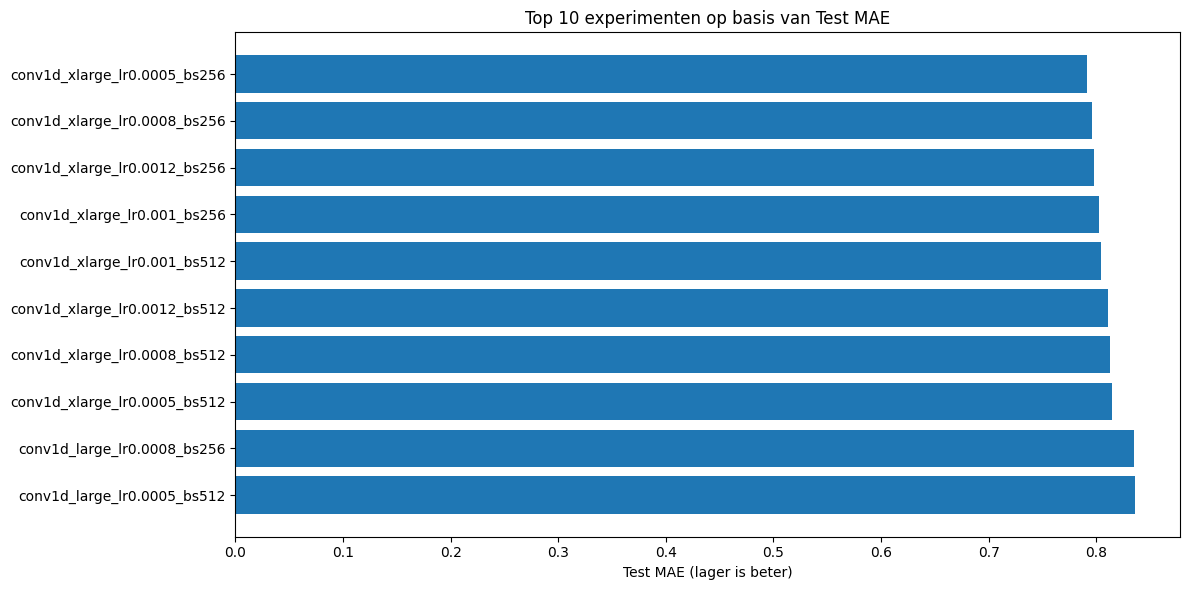

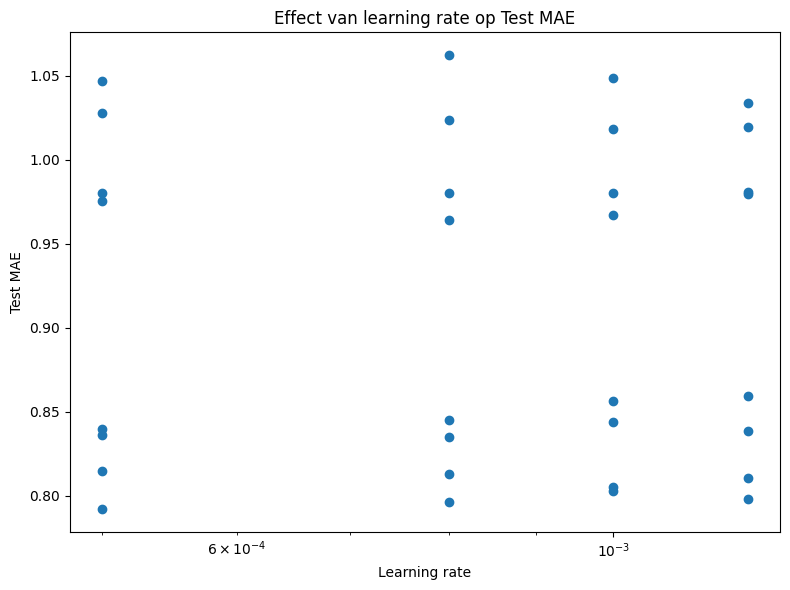

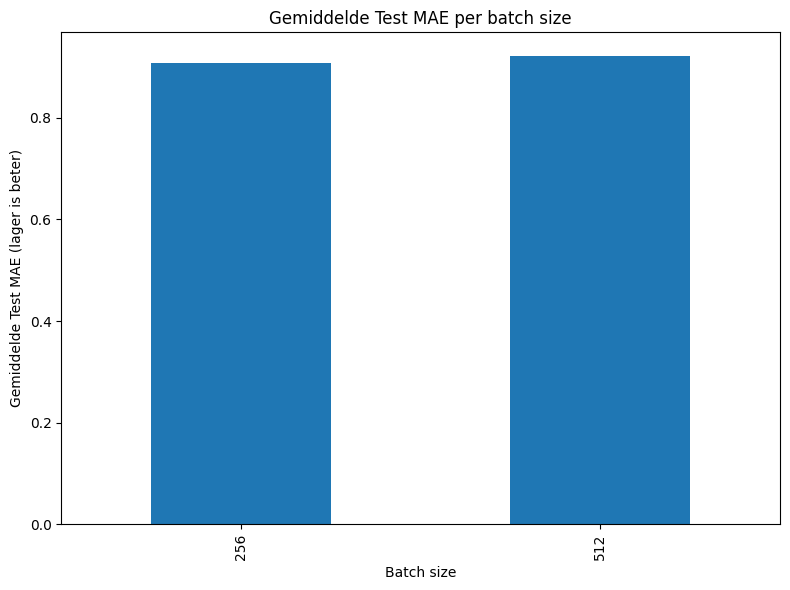


Best experiment based on test MAE:
label            conv1d_xlarge_lr0.0005_bs256
arch_name                       conv1d_xlarge
optimizer                                Adam
learning_rate                          0.0005
batch_size                                256
best_val_loss                        1.006814
best_val_mae                         0.791577
test_loss                            1.007581
test_mae                             0.791763
Name: 8, dtype: object

Best experiment based on test MAE:
label            conv1d_xlarge_lr0.0005_bs256
arch_name                       conv1d_xlarge
optimizer                                Adam
learning_rate                          0.0005
batch_size                                256
best_val_loss                        1.006814
best_val_mae                         0.791577
test_loss                            1.007581
test_mae                             0.791763
Name: 8, dtype: object
                           label      arch_name optimi

In [7]:
print("TensorFlow version:", tf.__version__)
print("Loading dataset...")

boards, scores = build_dataset(DATASET_PATH)

# ---- Train / Val / Test split ----
N = len(boards)
test_size = int(N * 0.2)
val_size  = int((N - test_size) * 0.2)

X_test = boards[:test_size]
y_test = scores[:test_size]

X_trainval = boards[test_size:]
y_trainval = scores[test_size:]

X_val = X_trainval[:val_size]
y_val = y_trainval[:val_size]

X_train = X_trainval[val_size:]
y_train = y_trainval[val_size:]

print(f"Train size: {len(X_train)}")
print(f"Val size:   {len(X_val)}")
print(f"Test size:  {len(X_test)}")

# hyperparameter search
results, df = run_experiments(X_train, y_train, X_val, y_val, X_test, y_test)

# eventueel: beste config tonen
best_row = df.sort_values("test_mae").iloc[0]
print("\nBest experiment based on test MAE:")
print(best_row)

print(df)
print (results)
